In [1]:
%load_ext cudf

The cudf module is not an IPython extension.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
pd.set_option('display.max_columns', None)

In [4]:
def feature_engineering_EEG(df: pd.DataFrame, i: int):
    # Step 1: Drop unwanted columns
    df.drop(["Elements", "HeadBandOn", "AUX_RIGHT", "TimeStamp", "UnixTime", "Battery"],
            axis=1, inplace=True, errors="ignore")

    # Step 2: Fill QuestionKey NaN with 'None'
    df['QuestionKey'].fillna('None', inplace=True)

    # Step 3: Convert HSI values into flags (0 = good, 1 = bad)
    signal_flags_values = {1: 0, 2: 0, 4: 1, 1.0: 0, 2.0: 0, 4.0: 1}
    for col in ['HSI_TP9','HSI_TP10','HSI_AF7','HSI_AF8']:
        flag_col = col + '_flag'
        df.loc[:, flag_col] = df[col].map(signal_flags_values).fillna(1).astype(np.int8)
    df.drop(['HSI_TP9', 'HSI_TP10', 'HSI_AF7', 'HSI_AF8'], axis=1, inplace=True, errors="ignore")

    # Step 4: Drop raw EEG channels
    raw_cols = ['RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10']
    df.drop(raw_cols, axis=1, inplace=True, errors="ignore")

    # Step 5: Fill missing values (forward/backward)
    df = df.ffill().bfill()

    # Step 6: Group by QuestionKey and aggregate other columns (e.g., mean)
    # Exclude non-numeric columns before calculating the mean, then merge with QuestionKey
    numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
    if 'QuestionKey' in numeric_cols:
        numeric_cols.remove('QuestionKey') # Ensure QuestionKey is not included in mean calculation

    aggreated_df = df.groupby('QuestionKey')[numeric_cols].mean().reset_index()


    # Step 8: Add student ID
    aggreated_df['Student'] = i

    return aggreated_df

In [5]:
def feature_engineering_EYE(df: pd.DataFrame, i: int):
    # Step 1: Drop irrelevant columns
    df.drop(["UnixTime", "Row", "Timestamp", "ET_TimeSignal", "ET_PupilLeft", "ET_PupilRight"], axis=1, inplace=True, errors="ignore")

    # Step 2: Fill missing QuestionKey
    df['QuestionKey'].fillna('None', inplace=True)

    # Step 3: Map validity values
    validity_map = { 4.0: 1, 0.0: 0, 4: 1, 0: 0 }
    df['ET_ValidityLeft']  = df['ET_ValidityLeft'].map(validity_map).fillna(0).astype(np.int8)
    df['ET_ValidityRight'] = df['ET_ValidityRight'].map(validity_map).fillna(0).astype(np.int8)


    # Step 5: Replace -1 with NaN, forward/backward fill
    df.replace({-1: np.nan}, inplace=True)
    df = df.ffill().bfill()

    # Step 6:
    numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
    if 'QuestionKey' in numeric_cols:
        numeric_cols.remove('QuestionKey') # Ensure QuestionKey is not included in mean calculation

    aggreated_df = df.groupby('QuestionKey')[numeric_cols].mean().reset_index()

    # Step 7: Add student ID
    aggreated_df['Student'] = i

    return aggreated_df


In [6]:
def feature_engineering_IVT(df: pd.DataFrame, i: int):
    # Step 1: Drop unneeded columns
    drop_cols = [
        "UnixTime", "Row", "Timestamp",
        "Fixation Index", "Saccade Index",
        "Fixation Start", "Fixation End",
        "Saccade Start", "Saccade End",
        "Fixation Index by Stimulus", "Saccade Index by Stimulus",
        "Interpolated Gaze X", "Interpolated Gaze Y"
    ]
    df.drop(drop_cols, axis=1, inplace=True, errors="ignore")

    # Step 2: Handle missing QuestionKey
    df['QuestionKey'].fillna('None', inplace=True)

    gaze_features_columns = ['Gaze X', 'Gaze Y', 'Interpolated Distance', 'Gaze Velocity','Gaze Acceleration']

    gaze_features = df.groupby('QuestionKey')[gaze_features_columns].mean().reset_index()


    fix_df = df.dropna(subset=['Fixation Duration'])

    fix_feature = fix_df.groupby('QuestionKey').agg({
        'Fixation Duration': ['count','mean','max','sum','var'],
        'Fixation Dispersion': ['mean','max'],
        'Fixation X': ['var'],
        'Fixation Y': ['var']
    })

    fix_feature.columns = [
        'fix_count','fix_mean_dur','fix_max_dur','fix_total_time','fix_dur_var',
        'fix_disp_mean','fix_disp_max',
        'fix_x_var','fix_y_var'
    ]
    fix_feature.reset_index(inplace=True)

    # -------------------------------
    # Step 5: Saccade features
    # -------------------------------
    sac_df = df.dropna(subset=['Saccade Duration'])

    sac_features = sac_df.groupby('QuestionKey').agg({
        'Saccade Duration': ['count','mean','sum'],
        'Saccade Amplitude': ['mean','max'],
        'Saccade Peak Velocity': ['mean','max'],
        'Saccade Peak Acceleration': ['mean'],
        'Saccade Peak Deceleration': ['mean'],
        'Saccade Direction': ['var']
    })

    sac_features.columns = [
        'sac_count','sac_mean_dur','sac_total_time',
        'sac_amp_mean','sac_amp_max',
        'sac_vel_mean','sac_vel_max',
        'sac_acc_mean','sac_dec_mean','sac_dir_var'
    ]
    sac_features.reset_index(inplace=True)

    # -------------------------------
    # Step 6: Merge fixation & saccade
    # -------------------------------
    ivt_features = fix_feature.merge(sac_features, on='QuestionKey', how='outer').fillna(0)

    # Validity flags
    ivt_features['fix_valid'] = (ivt_features['fix_count'] > 0).astype(int)
    ivt_features['sac_valid'] = (ivt_features['sac_count'] > 0).astype(int)

    # Fixation-to-saccade ratios
    ivt_features['fix_sac_count_ratio'] = ivt_features['fix_count'] / (ivt_features['sac_count']+1e-5)
    ivt_features['fix_sac_time_ratio']  = ivt_features['fix_total_time'] / (ivt_features['sac_total_time']+1e-5)

    # Normalized rates
    ivt_features['fix_rate'] = ivt_features['fix_count'] / (ivt_features['fix_total_time']+1e-5)
    ivt_features['sac_rate'] = ivt_features['sac_count'] / (ivt_features['sac_total_time']+1e-5)

    # -------------------------------
    # Step 7: Merge with gaze features
    # -------------------------------
    final_features = ivt_features.merge(gaze_features, on='QuestionKey', how="outer").fillna(0)

    # -------------------------------
    # Step 8: Add Student ID
    # -------------------------------
    final_features['Student'] = i

    return final_features


In [7]:
def feature_engineering_PSY(df: pd.DataFrame, i: int, encoding: str = "ordinal"):

    # Keep only needed cols
    df = df[['Key', 'Difficulty', 'ResponseTime']].copy()

    # Rename Key -> QuestionKey
    df.rename(columns={'Key': 'QuestionKey'}, inplace=True)

    # Encode Difficulty
    if encoding == "ordinal":
        # Map difficulty to numeric scale
        difficulty_map = {'Easy': 0, 'Medium': 1, 'Difficult': 2}
        df['Difficulty'] = df['Difficulty'].map(difficulty_map)
    elif encoding == "onehot":
        # One-hot encode difficulty
        df = pd.get_dummies(df, columns=['Difficulty'], prefix='Diff')

    # Add Student ID
    df['Student'] = i

    return df


In [8]:
def combine_modalities(eeg_df: pd.DataFrame,
                       ivt_df: pd.DataFrame,
                       eye_df: pd.DataFrame,
                       psy_df: pd.DataFrame) -> pd.DataFrame:

    # Step 1: Merge EEG + IVT
    merged = eeg_df.merge(ivt_df,
                          on=['QuestionKey', 'Student'],
                          how='outer')

    # Step 2: Merge with EYE
    merged = merged.merge(eye_df,
                          on=['QuestionKey', 'Student'],
                          how='outer')

    # Step 3: Merge with PSY (inner join to keep only valid trials)
    merged = merged.merge(psy_df,
                          on=['QuestionKey', 'Student'],
                          how='inner')

    # Step 4: Handle NaNs (fill with 0 for missing features)
    merged.fillna(0, inplace=True)

    return merged


In [9]:
def feature_engineering():
  all_students_data = []

  for student_id in range(1, 39):  # 38 students
      # Load student data (replace with your file paths)
      df_eeg = pd.read_csv(f"data/STData/{student_id}/{student_id}_EEG.csv")
      df_ivt = pd.read_csv(f"data/STData/{student_id}/{student_id}_IVT.csv")
      df_eye = pd.read_csv(f"data/STData/{student_id}/{student_id}_EYE.csv")
      df_psy = pd.read_csv(f"data/STData/{student_id}/{student_id}_PSY.csv")

      # Feature engineering per modality
      eeg_features = feature_engineering_EEG(df_eeg, student_id)
      ivt_features = feature_engineering_IVT(df_ivt, student_id)
      eye_features = feature_engineering_EYE(df_eye, student_id)
      psy_features = feature_engineering_PSY(df_psy, student_id, encoding="ordinal")

      # Merge modalities for this student
      student_data = combine_modalities(eeg_features, ivt_features, eye_features, psy_features)

      # Append to list
      all_students_data.append(student_data)

  # Combine all students into one big dataset
  final_dataset = pd.concat(all_students_data, ignore_index=True)

  return final_dataset

In [10]:
final_df = feature_engineering()

/tmp/ipykernel_50389/2772768456.py:6: DtypeWarning: Columns (2,40) have mixed types. Specify dtype option on import or set low_memory=False.
  df_eeg = pd.read_csv(f"data/STData/{student_id}/{student_id}_EEG.csv")
/tmp/ipykernel_50389/2653399823.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['QuestionKey'].fillna('None', inplace=True)
/tmp/ipykernel_50389/1262372528.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will 

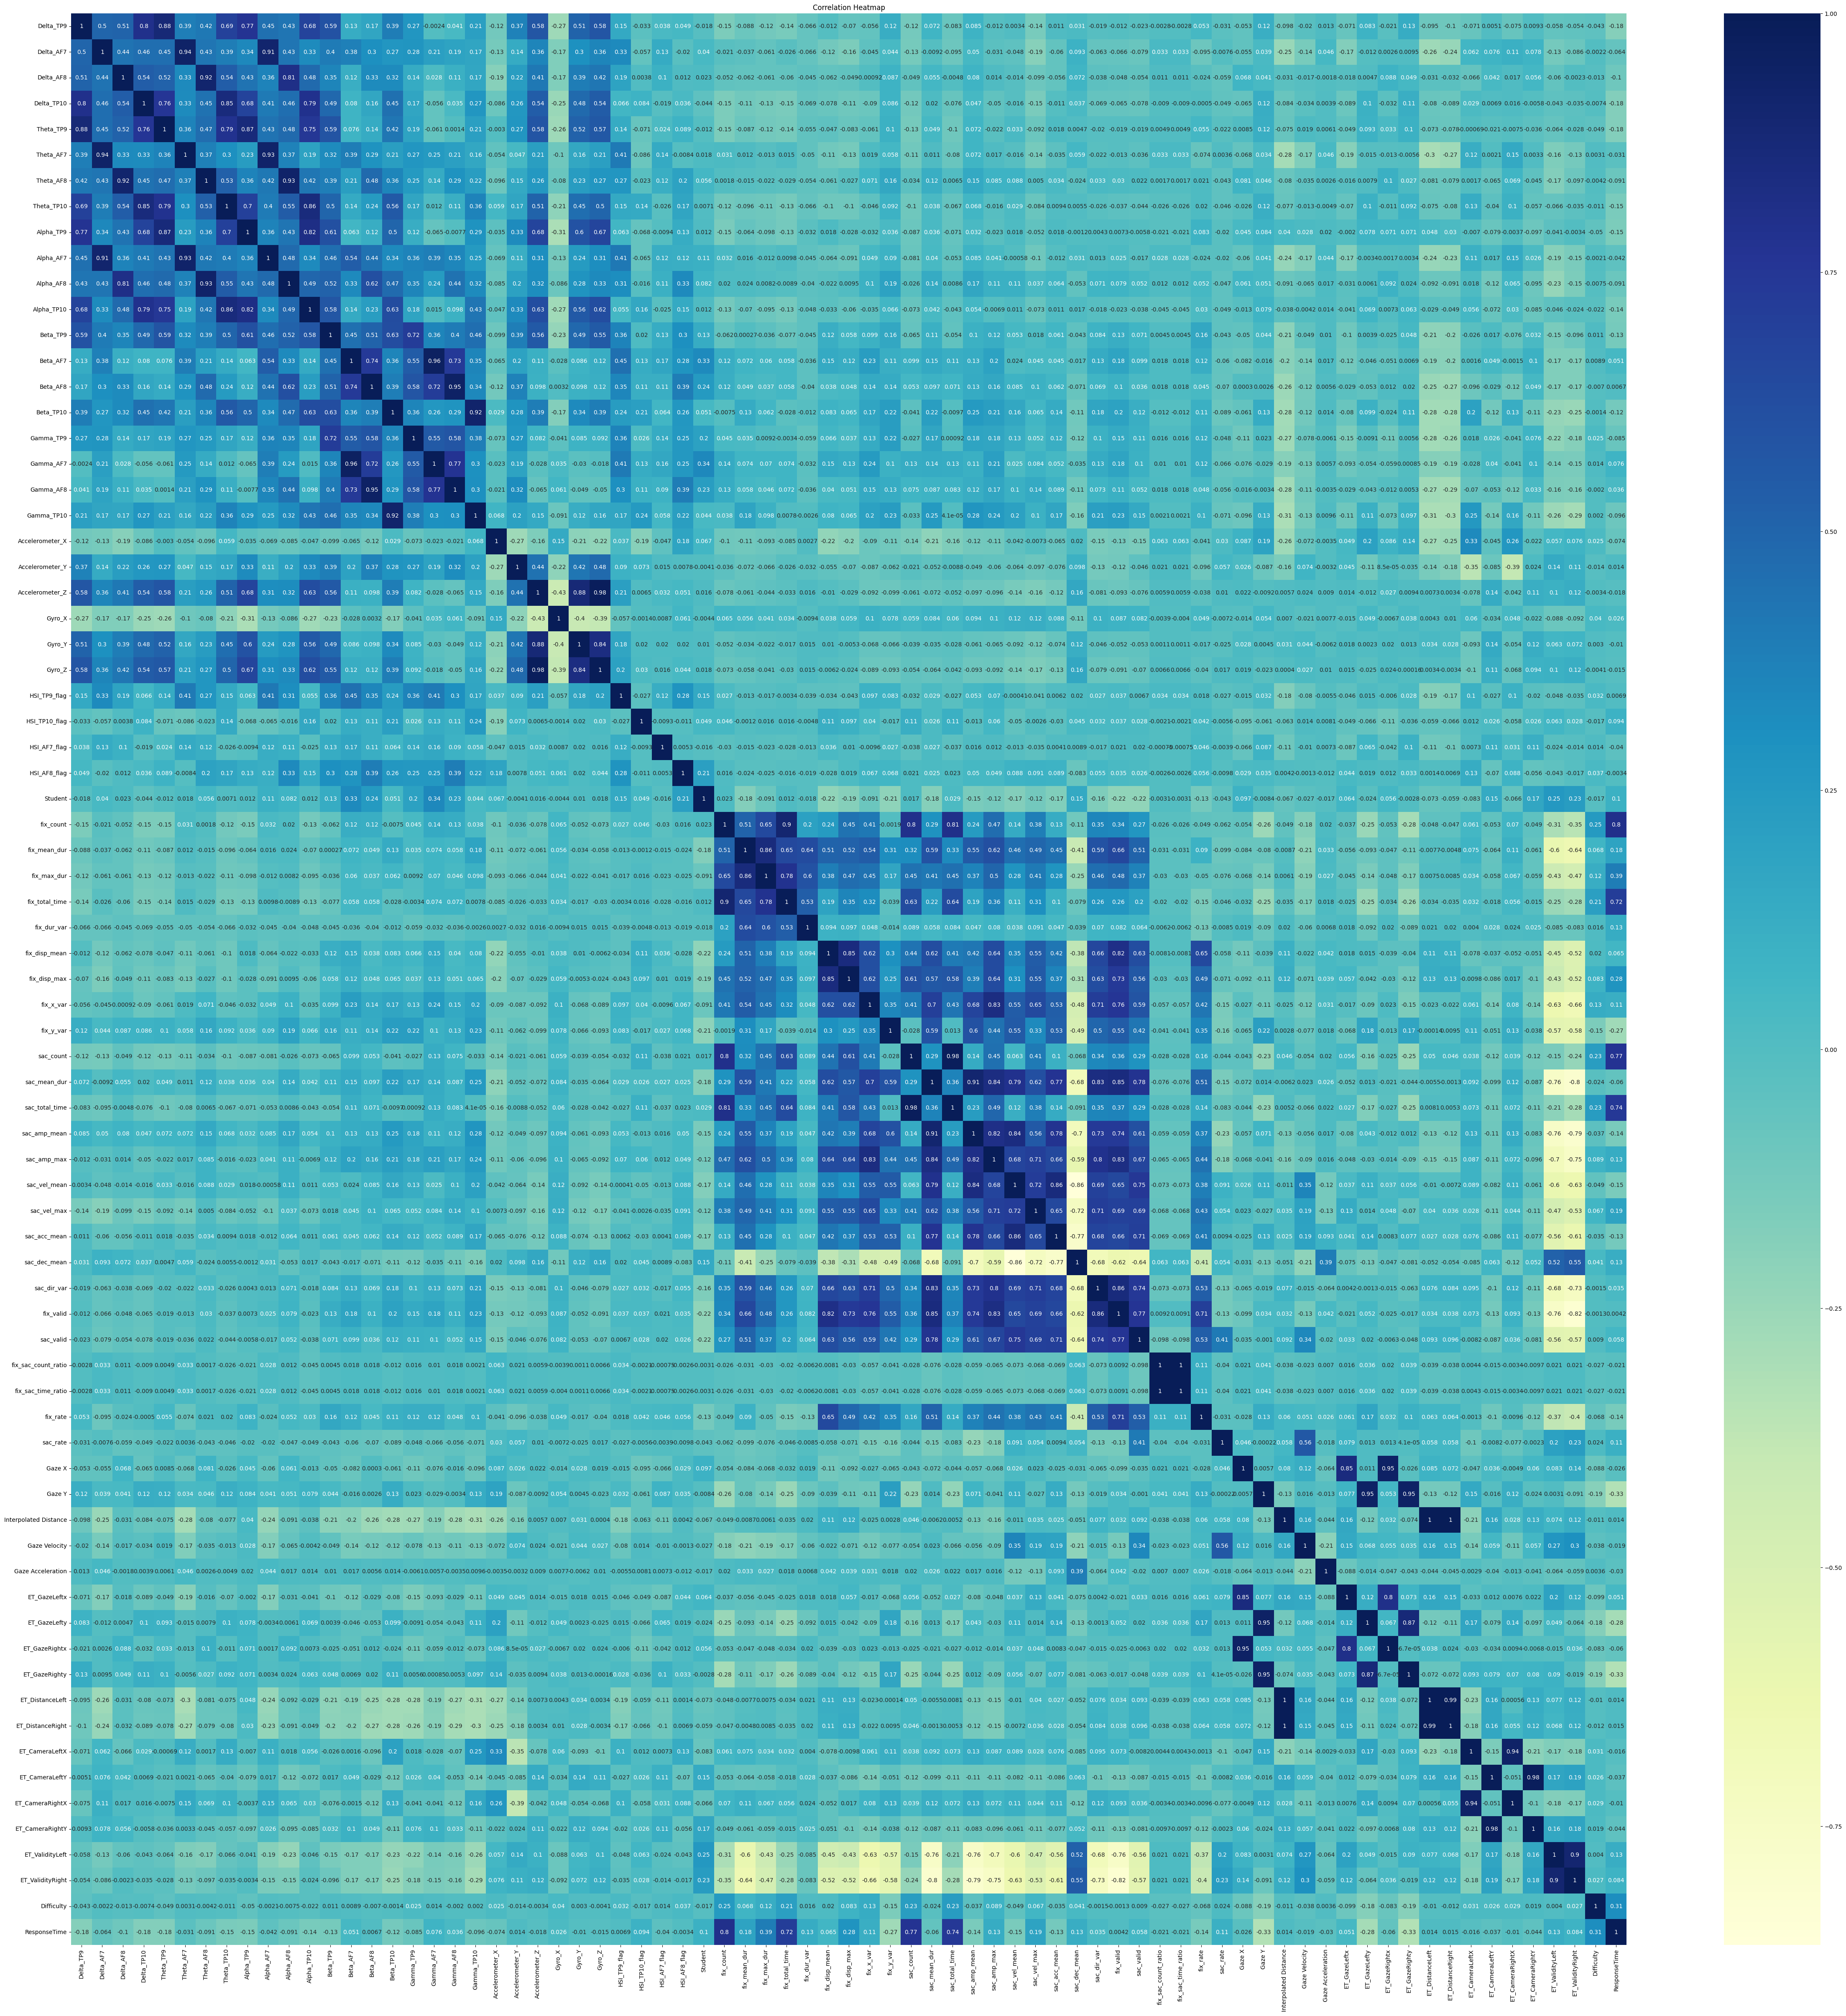

In [11]:
plt.figure(figsize=(60, 60))
sns.heatmap(final_df.corr(numeric_only=True), annot=True, cmap='YlGnBu')
plt.title('Correlation Heatmap')
plt.show()

In [12]:
final_df.shape

(1448, 76)

In [13]:
def drop_highly_correlated(df, threshold=0.9):
    # Compute correlation matrix only for numeric columns
    corr_matrix = df.corr(numeric_only=True).abs()

    # Take only upper triangle of the matrix
    upper = corr_matrix.where(
        np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
    )

    # Find columns to drop
    to_drop = [col for col in upper.columns if any(upper[col] > threshold)]

    # Return reduced DataFrame and list of dropped columns
    return df.drop(columns=to_drop), to_drop

In [14]:
reduced_df, dropped_cols = drop_highly_correlated(final_df, threshold=0.9)

In [15]:
print("Dropped columns:", dropped_cols)

Dropped columns: ['Theta_AF7', 'Theta_AF8', 'Alpha_AF7', 'Alpha_AF8', 'Gamma_AF7', 'Gamma_AF8', 'Gamma_TP10', 'Gyro_Z', 'fix_total_time', 'sac_total_time', 'sac_amp_mean', 'fix_sac_time_ratio', 'ET_GazeLefty', 'ET_GazeRightx', 'ET_GazeRighty', 'ET_DistanceLeft', 'ET_DistanceRight', 'ET_CameraRightX', 'ET_CameraRightY', 'ET_ValidityRight']


In [16]:
print("Original shape:", final_df.shape)

Original shape: (1448, 76)


In [17]:
print("Reduced shape:", reduced_df.shape)

Reduced shape: (1448, 56)


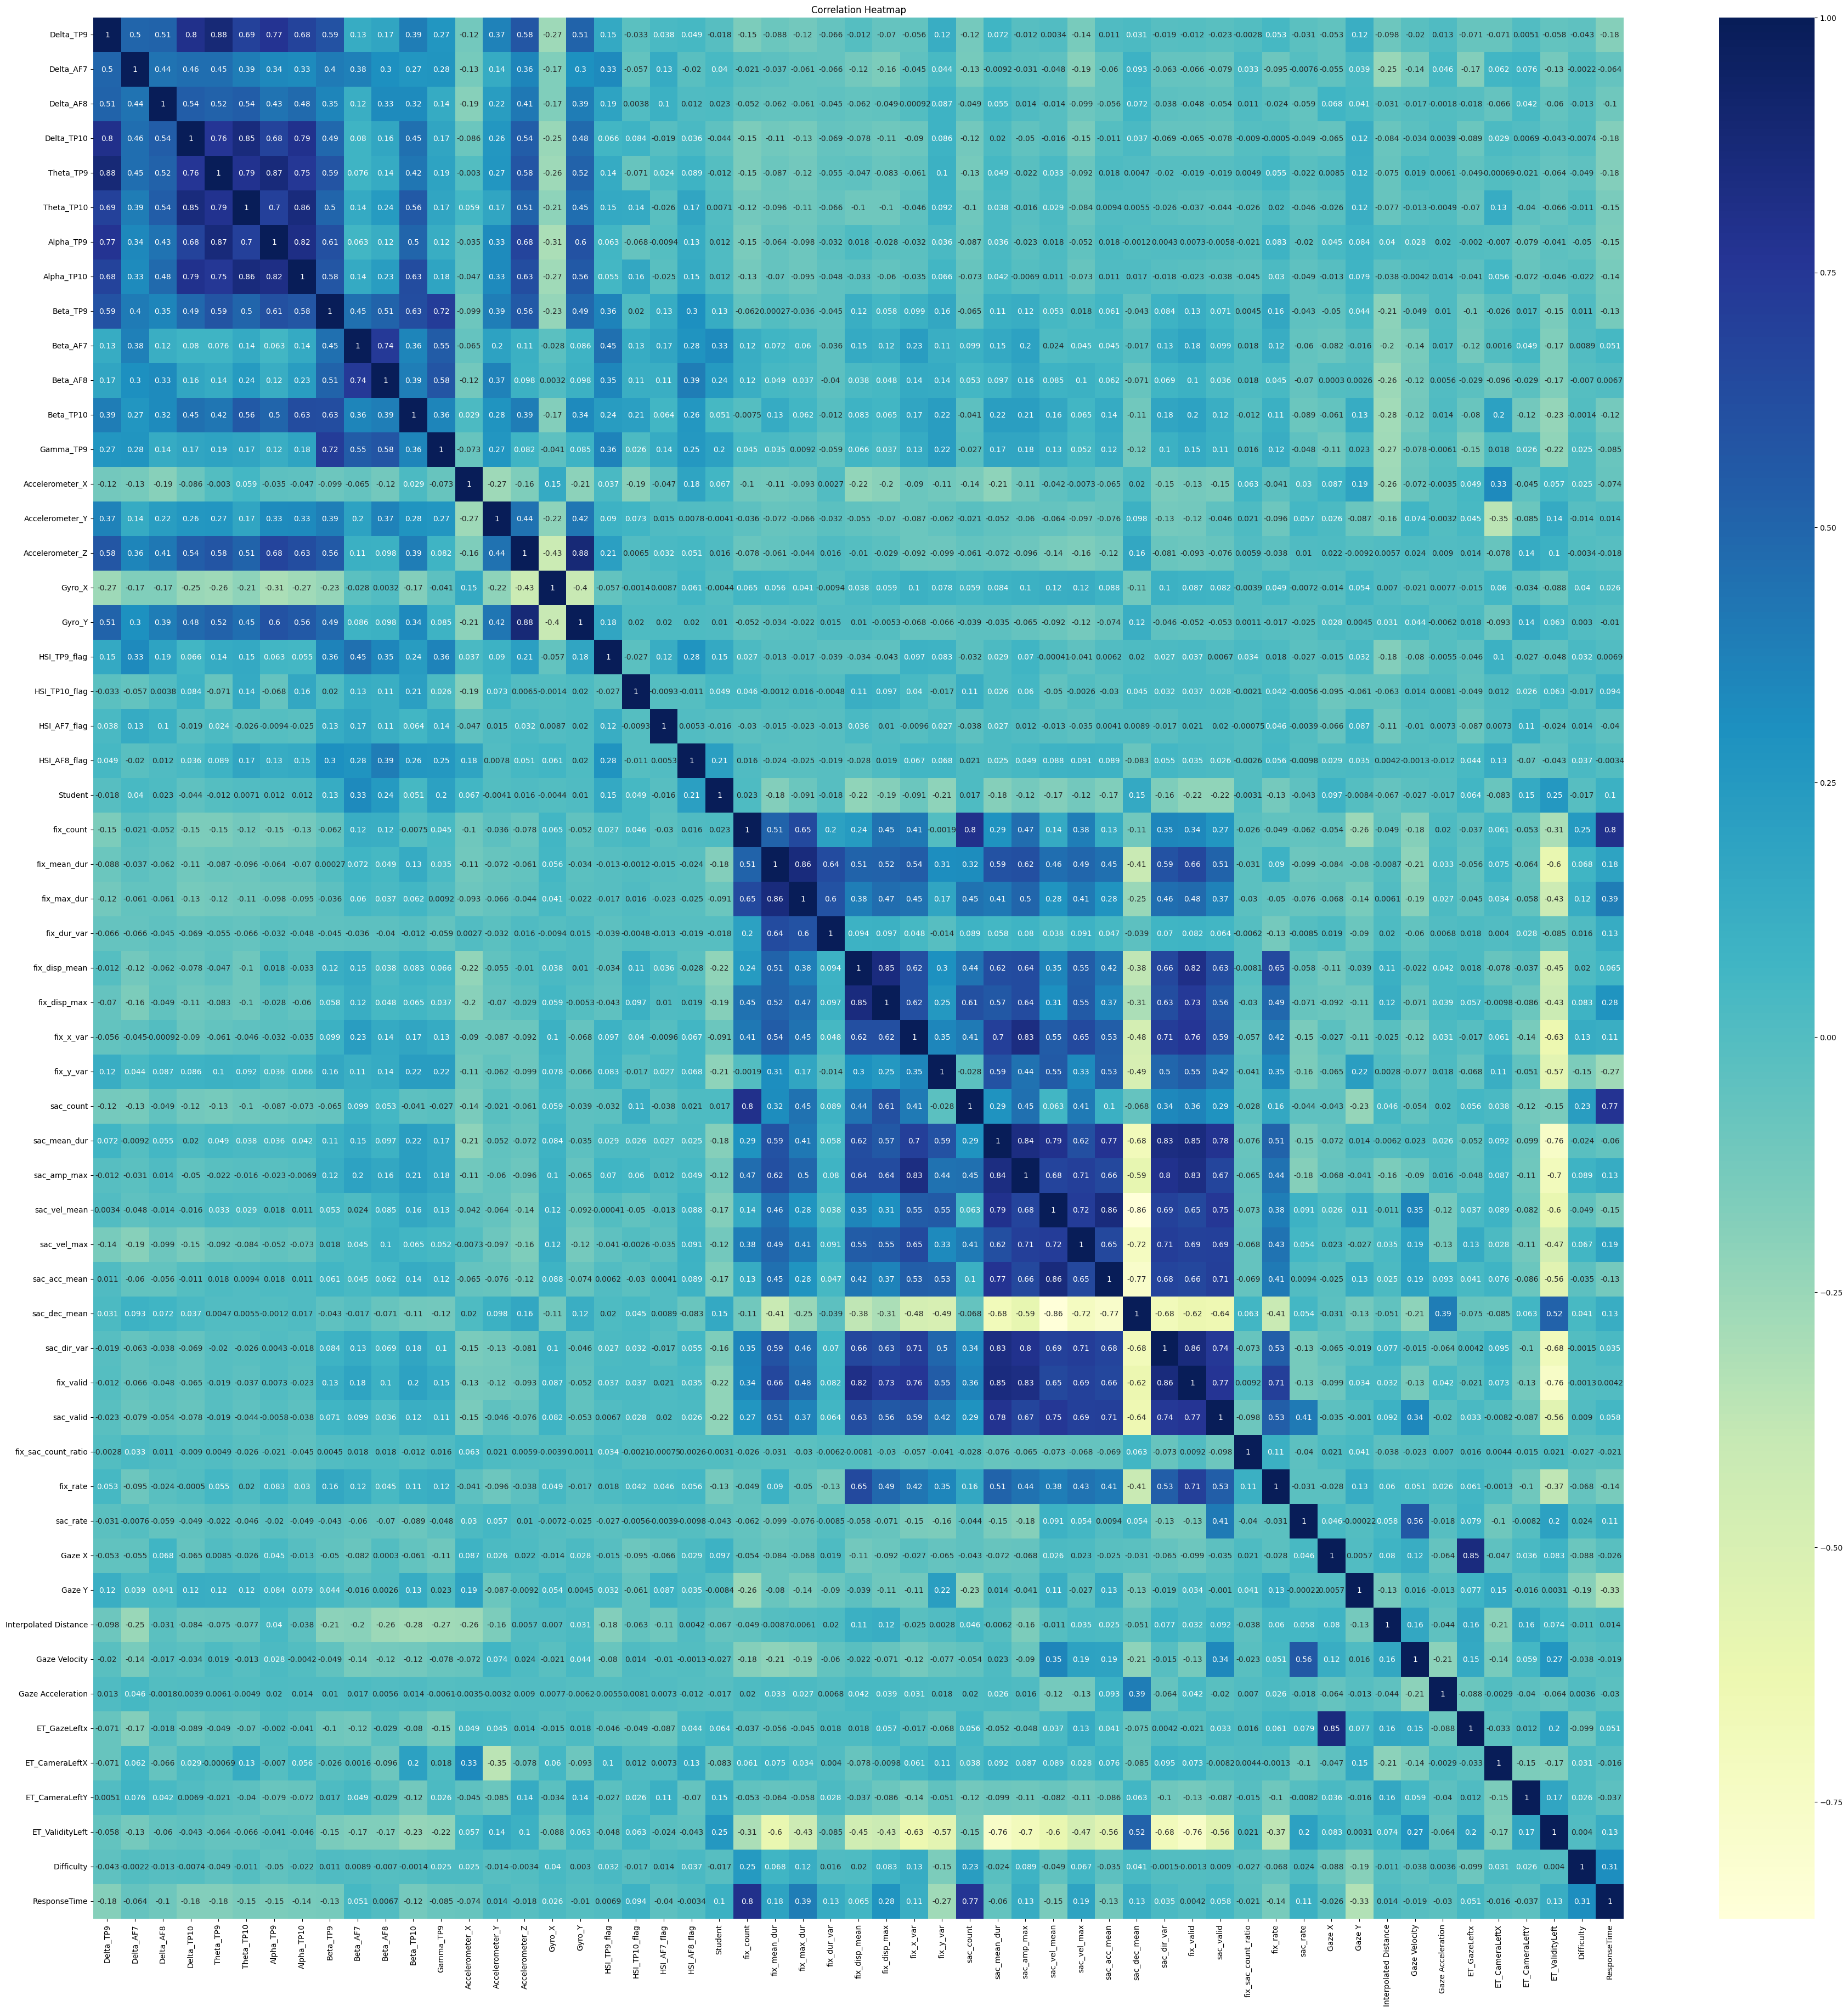

In [18]:
plt.figure(figsize=(45, 45))
sns.heatmap(reduced_df.corr(numeric_only=True), annot=True, cmap='YlGnBu')
plt.title('Correlation Heatmap')
plt.show()

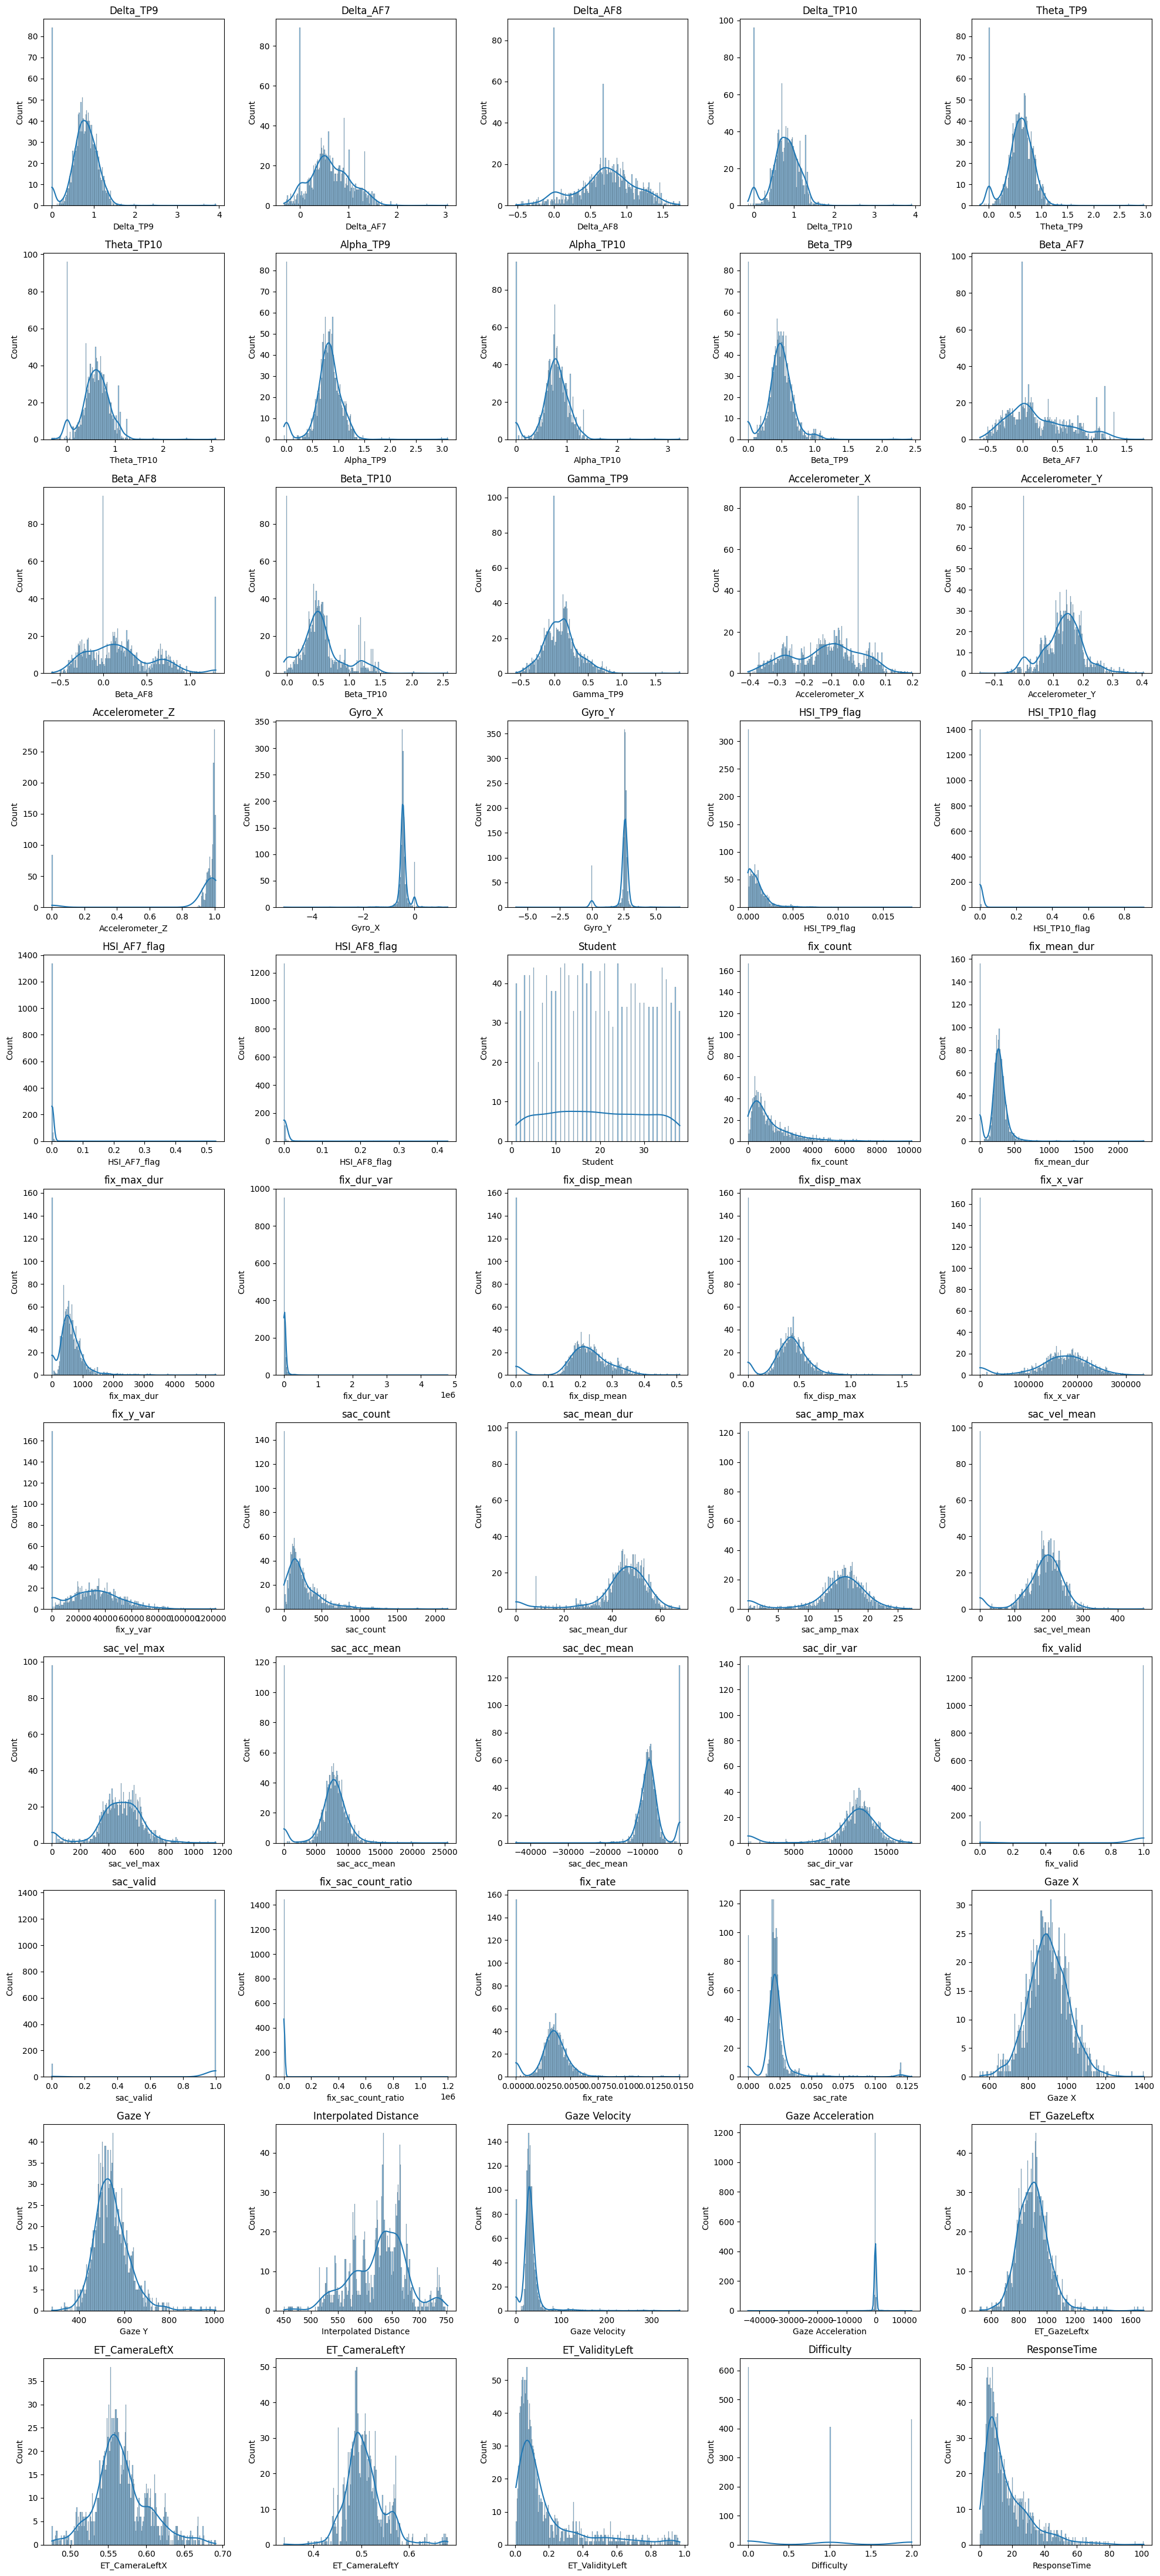

In [19]:
numeric_cols = reduced_df.select_dtypes(include=np.number).columns

n_cols = 5
n_rows = (len(numeric_cols) + n_cols - 1) // n_cols

plt.figure(figsize=(20, n_rows * 4))

for i, col in enumerate(numeric_cols):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.histplot(reduced_df[col].dropna(), bins=200, kde=True)  # much faster than sns.histplot
    plt.title(col)

plt.tight_layout()  # only once!
plt.show()

In [20]:
# Check for infinite values in the reduced DataFrame
infinite_values = reduced_df.isin([np.inf, -np.inf])
cols_with_infinite = infinite_values.any()

print("Columns with infinite values:")
for col, has_infinite in cols_with_infinite.items():
    if has_infinite:
        print(col)

Columns with infinite values:
Delta_TP10
Theta_TP10
Alpha_TP10
Beta_TP10


In [21]:
reduced_df.replace([np.inf, -np.inf], np.nan, inplace=True)

In [22]:
reduced_df.fillna(reduced_df.mean(numeric_only=True), inplace=True)

In [23]:
reduced_df.to_csv("data/feature_engineered_data/feature_engineered_type_1.csv", index=False)